### 1. Import libraries

We use `transformers` for the model, `datasets` to load AGNEWS, and PyTorch for training. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

2025-04-20 20:38:42.210760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745181522.672211      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745181522.794432      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Define helper classes

- `TestDataset`: used for formatting the Kaggle test data (`.pkl` file)
- `LoRALinear`: injects LoRA adapters into frozen attention layers

In [2]:
class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["text"]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0)
        }

In [3]:
# LoRA adapter module (r=rank, alpha=scaling factor)
class LoRALinear(nn.Module):
    def __init__(self, original_linear, r=4, alpha=32):
        super().__init__()
        self.original_linear = original_linear
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        for param in self.original_linear.parameters():
            param.requires_grad = False  # freeze base layer
        self.lora_A = nn.Parameter(torch.randn(self.original_linear.out_features, r) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(r, self.original_linear.in_features) * 0.01)

    def forward(self, x):
        original_output = self.original_linear(x)
        lora_out = (x @ self.lora_B.t()) @ self.lora_A.t()
        return self.original_linear(x) + self.scaling * ((x @ self.lora_B.t()) @ self.lora_A.t())

In [4]:
# Inject LoRA into attention query/value layers of each encoder block
def apply_lora(model, r=4, alpha=32):
    for layer in model.roberta.encoder.layer:
        layer.attention.self.query = LoRALinear(layer.attention.self.query, r, alpha)
        layer.attention.self.value = LoRALinear(layer.attention.self.value, r, alpha)
    return model

### 3. Load and preprocess AGNEWS dataset

We use only the training set, and split it into 90% train / 10% validation.

In [5]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
dataset = load_dataset("ag_news")

# Convert to DataFrame and split manually
df = dataset["train"].to_pandas()
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# Tokenize inputs to tensors
def tokenize_df(df):
    return tokenizer(list(df["text"]), truncation=True, padding="max_length", max_length=128, return_tensors="pt")

train_encodings = tokenize_df(train_df)
val_encodings = tokenize_df(val_df)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

### 4. Create PyTorch dataset objects

Wrap tokenized encodings with their labels into custom Dataset classes for training.

In [6]:
class AGNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

train_dataset = AGNewsDataset(train_encodings, list(train_df["label"]))
val_dataset = AGNewsDataset(val_encodings, list(val_df["label"]))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

### 5. Load RoBERTa and apply LoRA

We freeze all base weights and inject LoRA into attention layers.

In [7]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Freeze backbone
for param in model.roberta.parameters():
    param.requires_grad = False

# Inject LoRA (you can tune `r` and `alpha`)
model = apply_lora(model, r=8, alpha=24)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable Parameters:", count_trainable_parameters(model))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 888580


### 6. Train the model and validate

We use AdamW + linear warmup scheduler. Evaluation is done after each epoch.

In [8]:
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-4)
num_epochs = 3
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)

losses_every_100_steps = []
step = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

        if step % 100 == 0:
            losses_every_100_steps.append(loss.item())
        step += 1

    avg_loss = total_loss / len(train_dataloader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f"[Epoch {epoch+1}] Validation Accuracy: {accuracy:.4f}\n")

[Epoch 1] Training Loss: 0.2874
[Epoch 1] Validation Accuracy: 0.9422

[Epoch 2] Training Loss: 0.1728
[Epoch 2] Validation Accuracy: 0.9477

[Epoch 3] Training Loss: 0.1463
[Epoch 3] Validation Accuracy: 0.9508



### 7. Save the best model checkpoint

In [9]:
torch.save(model.state_dict(), "lora_roberta_agnews.pth")
print("Model saved as lora_roberta_agnews.pth")

Model saved as lora_roberta_agnews.pth


### 8. Loss Curve (every 100 mini-batches)

Below is the training loss plotted for every 100 mini-batches to show fine-grained training progression.


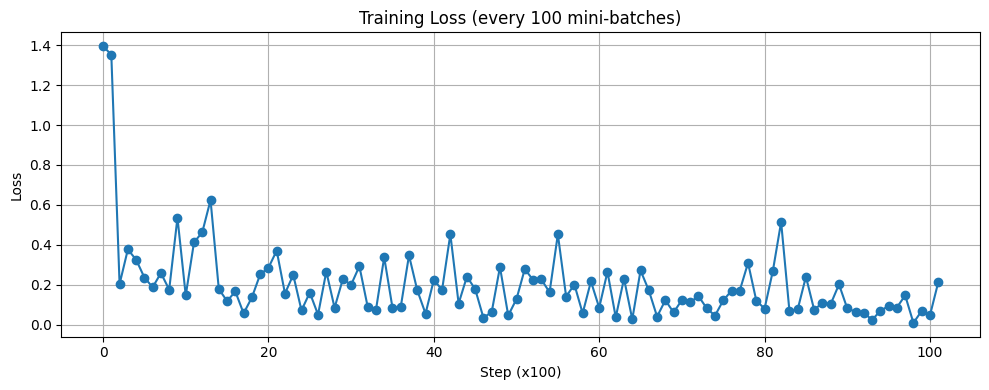

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(len(losses_every_100_steps)), losses_every_100_steps, marker='o')
plt.title("Training Loss (every 100 mini-batches)")
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### 9. Predict on unlabelled Kaggle test set

The predictions are saved to `submission.csv` in required format.

In [11]:
with open("/kaggle/input/test-dataset/test_unlabelled.pkl", "rb") as f:
    test_hf_dataset = pickle.load(f)

test_df = pd.DataFrame(test_hf_dataset)
test_dataset_custom = TestDataset(test_df, tokenizer)
test_dataloader_custom = DataLoader(test_dataset_custom, batch_size=32, shuffle=False)

model.eval()
all_predictions = []
with torch.no_grad():
    for batch in test_dataloader_custom:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_predictions.extend(preds.cpu().numpy())

submission_df = pd.DataFrame({
    "ID": range(len(all_predictions)),
    "Label": all_predictions
})
submission_df.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")

Submission saved as submission.csv
